In [4]:
# Import library yang kalian butuhkan
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
import seaborn as sns

In [5]:
def resize_image(img_path, size):
    try:
        img = cv.imread(img_path)
        if img is None:
            raise ValueError(f"Image at {img_path} could not be read.")
        resized_img = cv.resize(img, size)
        return resized_img
    except Exception as e:
        print(f"Error resizing image {img_path}: {e}")
        return None

Loading dataset...
Dataset loaded with 400 images across 4 classes.


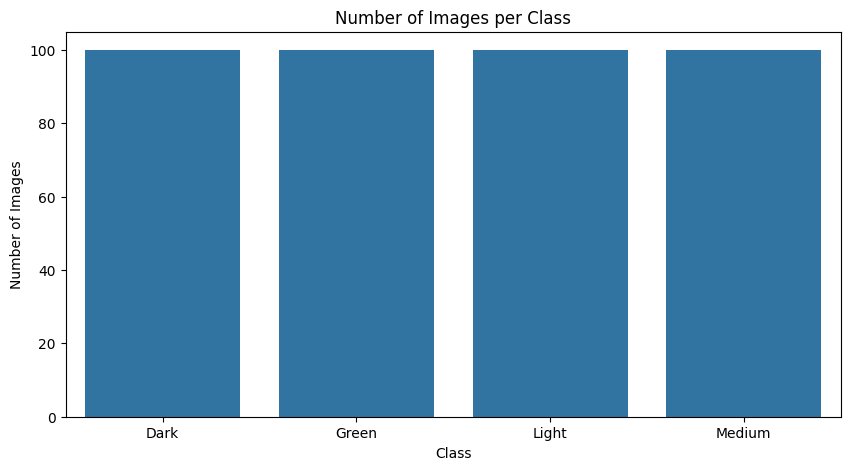

In [6]:
def load_dataset(dir):
    size = (250,250)
    images = []
    labels = []
    class_names = os.listdir(dir)
    class_counter = {class_name: 0 for class_name in class_names}

    for label, class_name in enumerate(class_names):
        class_dir = os.path.join(dir, class_name)
        if os.path.isdir(class_dir):
            for file_name in os.listdir(class_dir):
                if class_counter[class_name] >= 100:
                    break
                img_path = os.path.join(class_dir, file_name)
                img = resize_image(img_path, size)
                if img is not None:
                    images.append(img)
                    labels.append(class_name)
                    class_counter[class_name]+=1
    return np.array(images), np.array(labels), class_names, class_counter


print("Loading dataset...")
images, labels, class_names, class_counter = load_dataset('dataset')
print(f"Dataset loaded with {len(images)} images across {len(class_names)} classes.")
# Diagram Dataset
plt.figure(figsize=(10, 5))
sns.barplot(x=list(class_counter.keys()), y=list(class_counter.values()))
plt.title('Number of Images per Class')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.savefig('dataset_distribution.png')
plt.show()

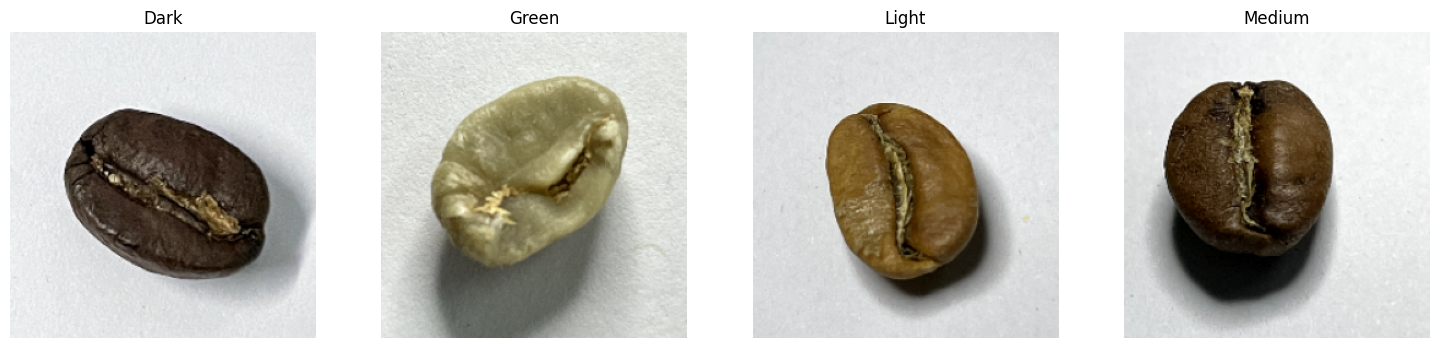

In [7]:
# Menampilkan gambar sample dari setiap kelas
def show_sample_images(images, labels, class_names):
    plt.figure(figsize=(15, 10))
    for i, class_name in enumerate(class_names):
        class_images = images[labels == class_name]
        if len(class_images) > 0:
            plt.subplot(3, 4, i + 1)
            plt.imshow(cv.cvtColor(class_images[10], cv.COLOR_BGR2RGB))
            plt.title(class_name)
            plt.axis('off')
    plt.tight_layout()
    plt.show()
show_sample_images(images, labels, class_names)

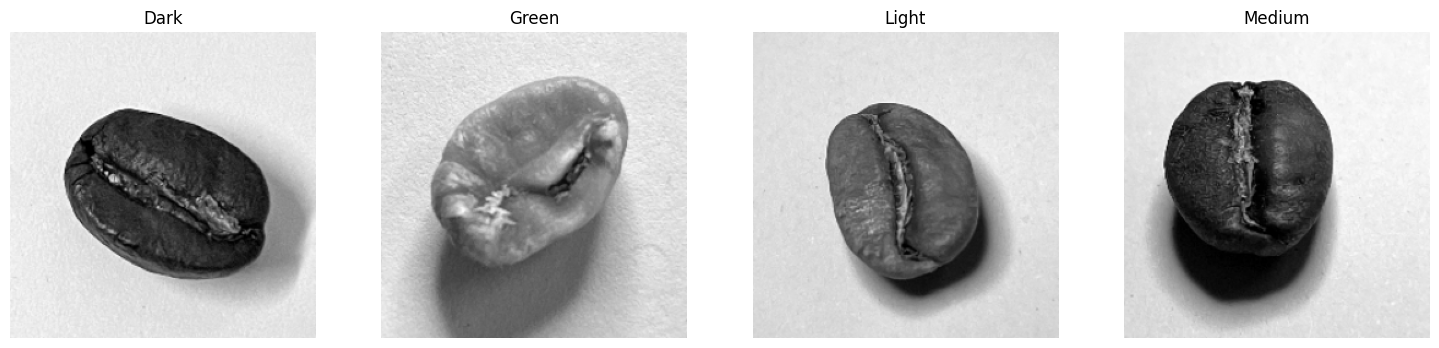

In [8]:
img_grey = []
for img in images:
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    img_grey.append(gray)
img_grey = np.array(img_grey)

show_sample_images(img_grey, labels, class_names)

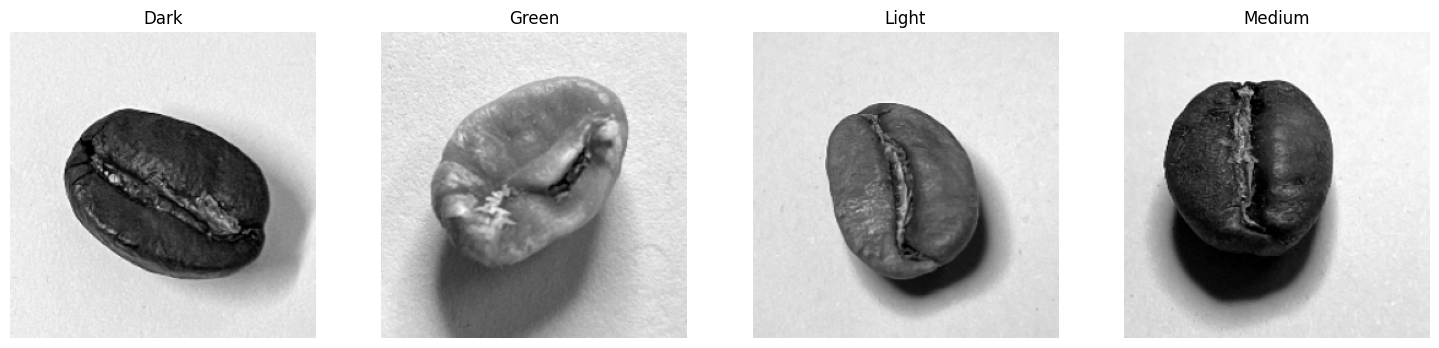

In [9]:
# Fungsi normalisasi gambar
def normalize_image(img, new_min=0, new_max=255):
    """
    Normalisasi gambar ke range [new_min, new_max]
    """
    # Konversi ke float untuk menghindari overflow
    img = img.astype(np.float32)
    
    # Hitung min dan max dari gambar asli
    old_min = np.min(img)
    old_max = np.max(img)
    
    # Hindari pembagian dengan nol (jika semua pixel bernilai sama)
    if old_max == old_min:
        return np.zeros_like(img, dtype=np.uint8) + new_min
    
    # Rumus normalisasi
    normalized = ((img - old_min) / (old_max - old_min)) * (new_max - new_min) + new_min
    
    # Konversi kembali ke uint8
    return normalized.astype(np.uint8)

# Proses normalisasi untuk img_grey
img_normalized = []
for img in img_grey:
    norm_img = normalize_image(img)
    img_normalized.append(norm_img)
img_normalized = np.array(img_normalized)

# Tampilkan sample gambar
show_sample_images(img_normalized, labels, class_names)

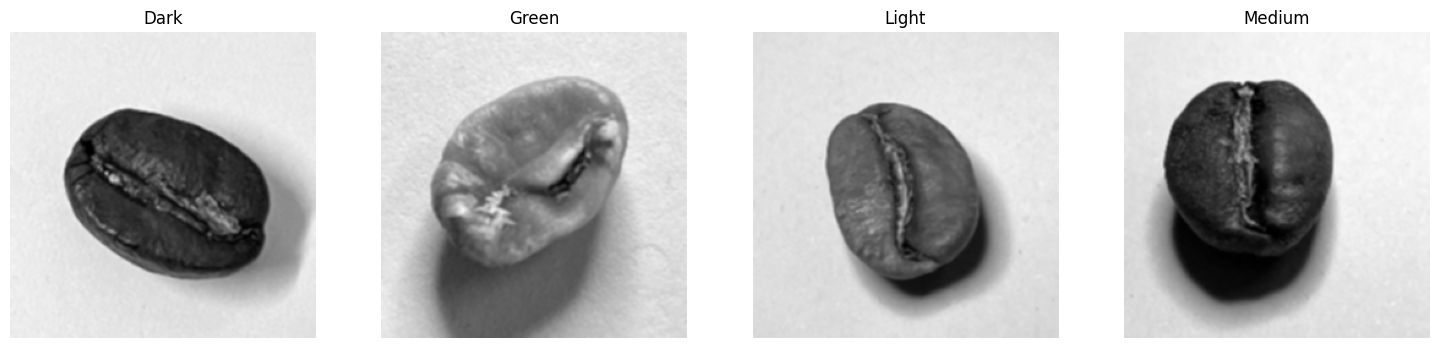

In [10]:
# Fungsi Smoothening
def smoothening(image):
    kernel = np.array([[1/10, 1/10, 1/10],
                             [1/10, 1/5,1/10],
                             [1/10, 1/10, 1/10]])
    return cv.filter2D(image, -1, kernel)
# Proses smoothening ke semua gambar
img_smooth = []
for img in img_normalized:
    smoothened_img = smoothening(img)
    img_smooth.append(smoothened_img)
img_smooth = np.array(img_smooth)
show_sample_images(img_smooth, labels, class_names)

In [11]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    
    # mengembalikan matrix glcm dari image
    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    return glcm

In [12]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

In [13]:
def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

In [14]:
def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

In [15]:
def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

In [16]:
def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

In [17]:
def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]

In [18]:
def entropyGlcm(matriks):
    return entropy(matriks.ravel())

In [19]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(img_smooth)):
    D0 = glcm(img_smooth[i], 0)
    D45 = glcm(img_smooth[i], 45)
    D90 = glcm(img_smooth[i], 90)
    D135 = glcm(img_smooth[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

In [20]:
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []


In [21]:
for i in range(len(img_smooth)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

In [22]:
for i in range(len(img_smooth)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

In [23]:
for i in range(len(img_smooth)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

In [24]:
for i in range(len(img_smooth)):
    H0 = homogenity(Derajat0[i])
    H45 = homogenity(Derajat45[i])
    H90 = homogenity(Derajat90[i])
    H135 = homogenity(Derajat135[i])
    homogenity0.append(H0)
    homogenity45.append(H45)
    homogenity90.append(H90)
    homogenity135.append(H135)

In [25]:
for i in range(len(img_smooth)):  
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

In [26]:
for i in range(len(img_smooth)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

In [27]:
for i in range(len(img_smooth)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)

In [28]:
dataTable = {'Filename': 'nopal', 'Label': labels,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_1.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_1.csv')
hasilEkstrak

,Filename,Label,Contrast0,Contrast45,Contrast90,Contrast135,Homogeneity0,Homogeneity45,Homogeneity90,Homogeneity135,...,ASM90,ASM135,Energy0,Energy45,Energy90,Energy135,Correlation0,Correlation45,Correlation90,Correlation135
0,nopal,Dark,50.244096,79.775633,34.618538,84.046790,0.479781,0.408548,0.506698,0.417833,...,0.005711,0.004515,0.074340,0.065697,0.075568,0.067194,0.995807,0.993354,0.997112,0.992999
1,nopal,Dark,38.688064,106.386332,58.035582,79.813906,0.509181,0.427588,0.493871,0.431963,...,0.015722,0.012192,0.123029,0.110764,0.125389,0.110417,0.997194,0.992302,0.995791,0.994225
2,nopal,Dark,42.985671,86.728666,38.105108,68.267334,0.440198,0.367427,0.466215,0.382920,...,0.005077,0.003737,0.067518,0.060190,0.071254,0.061129,0.996163,0.992277,0.996600,0.993921
3,nopal,Dark,34.313028,79.198303,39.370410,60.247544,0.460007,0.389895,0.472912,0.405498,...,0.008429,0.006304,0.086954,0.079001,0.091810,0.079398,0.996992,0.993072,0.996550,0.994730
4,nopal,Dark,37.755711,58.903873,38.586040,86.224287,0.438114,0.389674,0.477883,0.375284,...,0.007825,0.005649,0.081599,0.074557,0.088460,0.075157,0.996845,0.995089,0.996776,0.992811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,nopal,Medium,29.139855,63.357252,35.656819,61.665167,0.514727,0.440666,0.507437,0.432463,...,0.009182,0.007036,0.093805,0.084124,0.095824,0.083880,0.997388,0.994330,0.996804,0.994482
396,nopal,Medium,43.099888,67.348059,48.033462,106.183110,0.478905,0.422685,0.478222,0.406048,...,0.004294,0.003326,0.064633,0.057949,0.065526,0.057669,0.996830,0.995055,0.996467,0.992204
397,nopal,Medium,28.823695,71.330108,34.697382,50.591749,0.484330,0.405790,0.481523,0.419688,...,0.003210,0.002483,0.055938,0.049743,0.056656,0.049828,0.997571,0.994000,0.997077,0.995745
398,nopal,Medium,42.955422,70.303576,48.619920,104.003419,0.514092,0.453088,0.516298,0.445465,...,0.005523,0.004216,0.073009,0.065602,0.074317,0.064930,0.996861,0.994873,0.996446,0.992416


<Axes: >

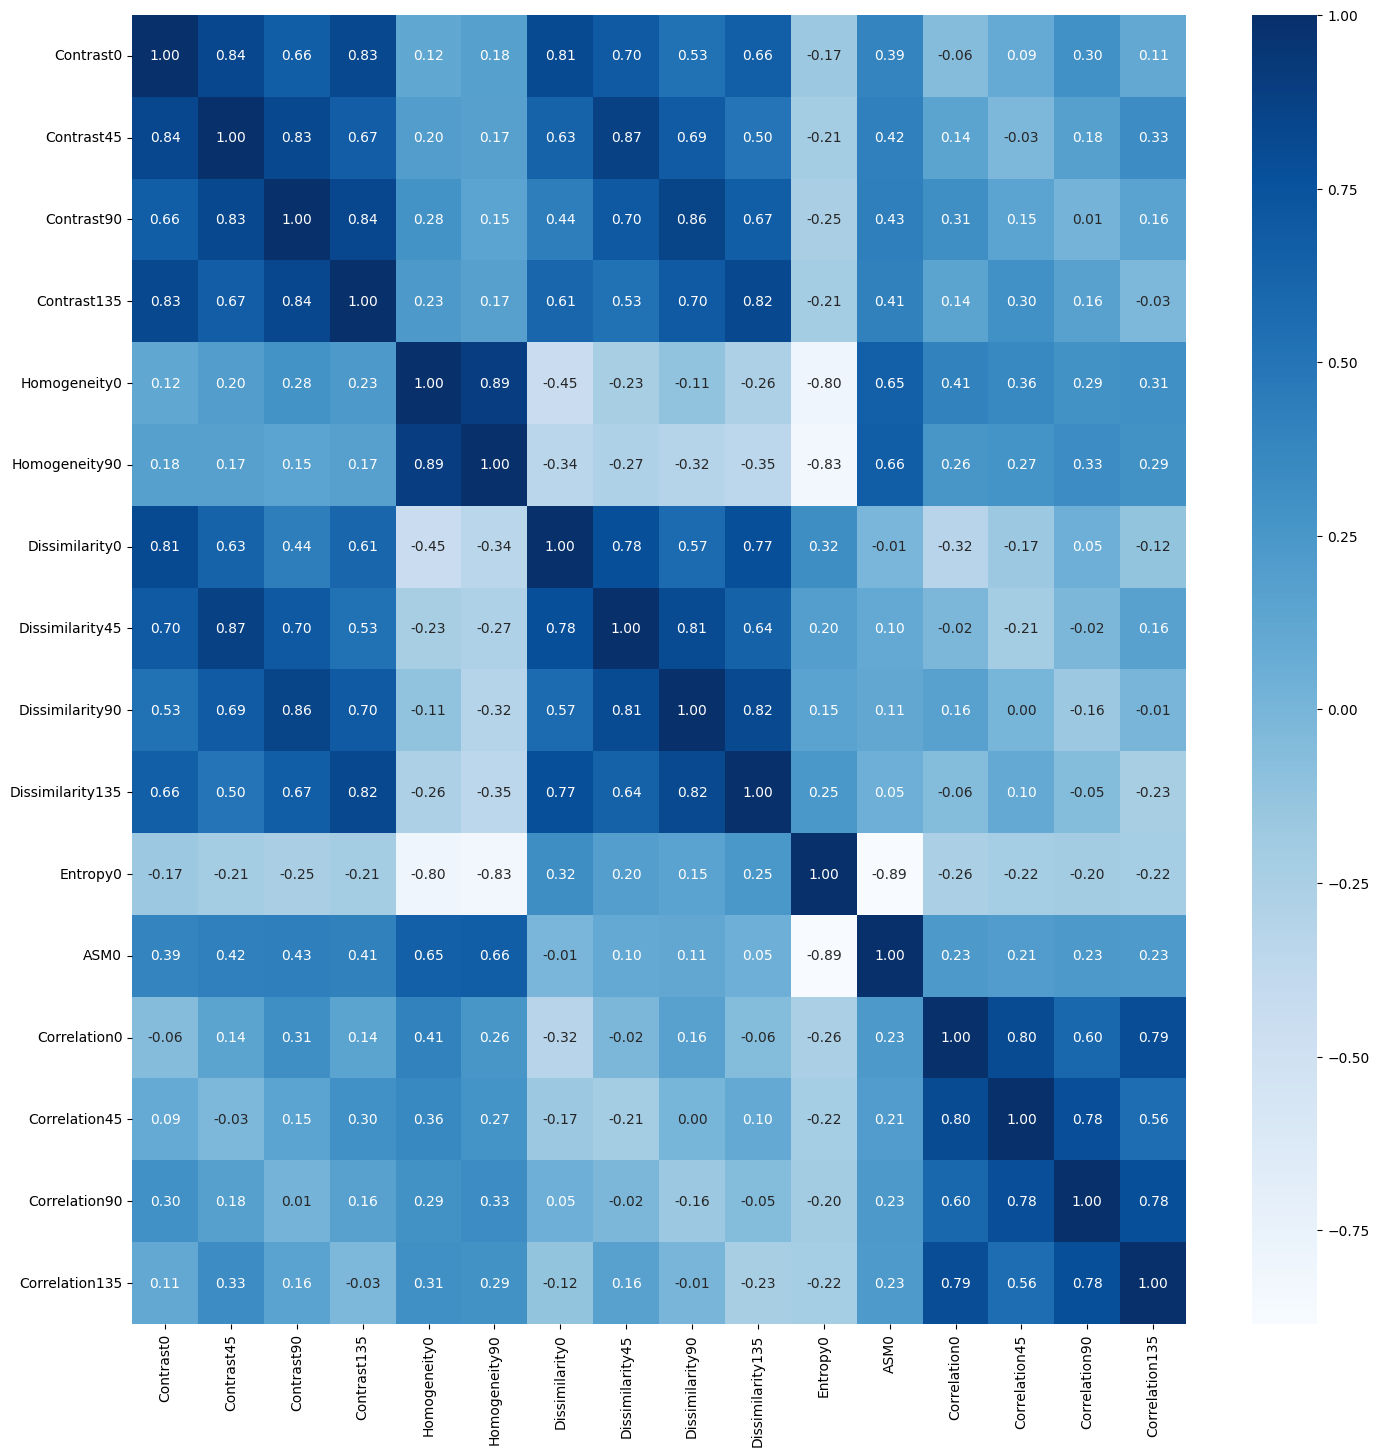

In [29]:
# Menghitung korelasi
correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()

# Menyaring fitur yang memiliki korelasi absolut lebih dari 0.95 dengan label
threshold = 0.95 # atur threshold ini untuk menentukan seberapa besar korelasi yang ingin disaring
selectionFeature = []
columns = np.full((correlation.shape[0],), True, dtype=bool)
for i in range(correlation.shape[0]):
	for j in range(i+1, correlation.shape[0]):
		if correlation.iloc[i,j] >= threshold:
			if columns[j]:
				columns[j] = False
select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]
x_new = hasilEkstrak[select]
x_new
y = hasilEkstrak['Label']
plt.figure(figsize=(17,17))
sns.heatmap(x_new.corr(), annot=True, cmap='Blues', fmt=".2f")

In [30]:
# ubah bagian test_size sesuai kebutuhan
# 0.3 = 30% data untuk testing (train/test 70/30)
# 0.2 = 20% data untuk testing (train/test 80/20)
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

(320, 16)
(80, 16)


In [31]:
# normalisasi mean std
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

In [32]:
def generateClassificationReport(y_true, y_pred):
	print(classification_report(y_true, y_pred))
	print(confusion_matrix(y_true, y_pred))
	print('Accuracy:', accuracy_score(y_true, y_pred))

# Define classifiers
rf = RandomForestClassifier(n_estimators=5, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

In [33]:
# Train Random Forest Classifier
rf.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------Training Set------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = rf.predict(X_test)
generateClassificationReport( y_test, y_pred)

------Training Set------
              precision    recall  f1-score   support

        Dark       0.94      0.99      0.96        74
       Green       1.00      1.00      1.00        82
       Light       0.98      1.00      0.99        82
      Medium       0.99      0.91      0.95        82

    accuracy                           0.97       320
   macro avg       0.97      0.98      0.97       320
weighted avg       0.98      0.97      0.97       320

[[73  0  0  1]
 [ 0 82  0  0]
 [ 0  0 82  0]
 [ 5  0  2 75]]
Accuracy: 0.975

------Testing Set------
              precision    recall  f1-score   support

        Dark       0.90      0.69      0.78        26
       Green       0.92      0.61      0.73        18
       Light       0.67      0.89      0.76        18
      Medium       0.62      0.83      0.71        18

    accuracy                           0.75        80
   macro avg       0.78      0.76      0.75        80
weighted avg       0.79      0.75      0.75        80

[[1

In [34]:
# Train SVM Classifier
svm.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = svm.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
              precision    recall  f1-score   support

        Dark       0.85      0.78      0.82        74
       Green       0.95      0.87      0.90        82
       Light       0.87      0.95      0.91        82
      Medium       0.82      0.87      0.84        82

    accuracy                           0.87       320
   macro avg       0.87      0.87      0.87       320
weighted avg       0.87      0.87      0.87       320

[[58  0  0 16]
 [ 0 71 11  0]
 [ 0  4 78  0]
 [10  0  1 71]]
Accuracy: 0.86875

------Testing Set------
              precision    recall  f1-score   support

        Dark       0.94      0.62      0.74        26
       Green       1.00      0.89      0.94        18
       Light       0.90      1.00      0.95        18
      Medium       0.63      0.94      0.76        18

    accuracy                           0.84        80
   macro avg       0.87      0.86      0.85        80
weighted avg       0.88      0.84      0.84        80



In [35]:
# Train KNN Classifier
knn.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = knn.predict(X_test)
generateClassificationReport( y_test, y_pred)



------Training Set------
              precision    recall  f1-score   support

        Dark       0.85      0.84      0.84        74
       Green       0.90      0.87      0.88        82
       Light       0.84      0.89      0.86        82
      Medium       0.84      0.83      0.83        82

    accuracy                           0.86       320
   macro avg       0.86      0.86      0.86       320
weighted avg       0.86      0.86      0.86       320

[[62  0  0 12]
 [ 0 71 11  0]
 [ 0  8 73  1]
 [11  0  3 68]]
Accuracy: 0.85625

------Testing Set------
              precision    recall  f1-score   support

        Dark       0.84      0.62      0.71        26
       Green       0.93      0.72      0.81        18
       Light       0.72      0.72      0.72        18
      Medium       0.52      0.83      0.64        18

    accuracy                           0.71        80
   macro avg       0.75      0.72      0.72        80
weighted avg       0.76      0.71      0.72        80



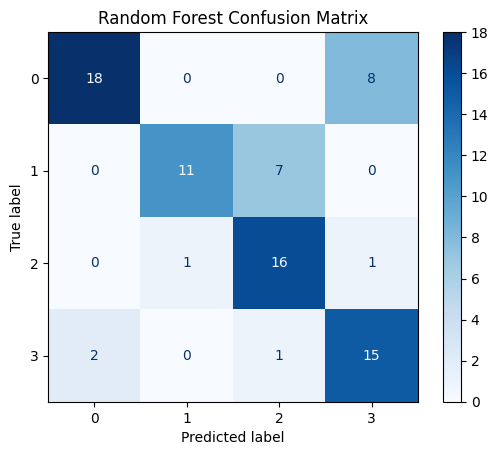

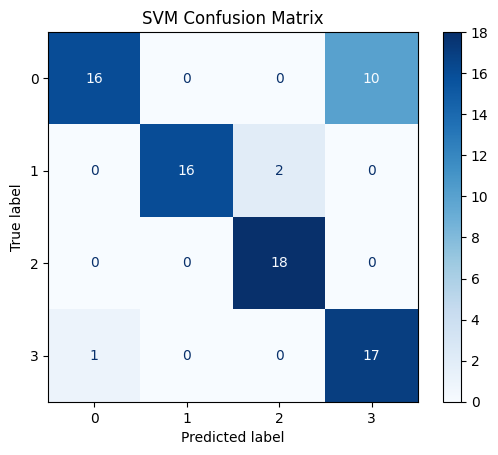

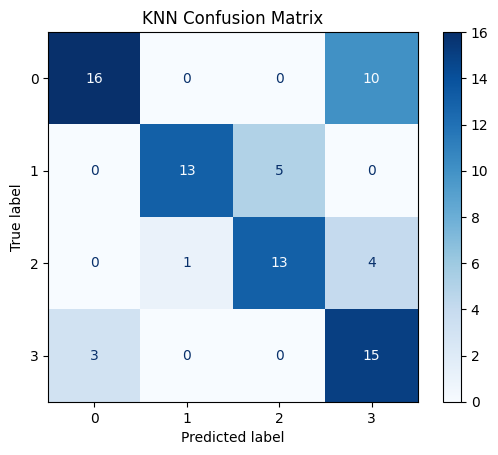

In [36]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf.predict(X_test), "Random Forest Confusion Matrix")
# Plot confusion matrix for SVM
plot_confusion_matrix(y_test, svm.predict(X_test), "SVM Confusion Matrix")
# Plot confusion matrix for KNN
plot_confusion_matrix(y_test, knn.predict(X_test), "KNN Confusion Matrix")